<a href="https://colab.research.google.com/github/quangvu32/quangvu32/blob/Deep-learning/%5B21522801%5D_ImageClassification_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Inport necessary packages

In [44]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt

In [3]:
import random
import numpy as np

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import os
import cv2

In [5]:
seed = 21522801

In [7]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Load Folio Leaf Dataset

In [45]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [9]:
root_dir="/content/MyDrive/MyDrive/Colab/Folio Leaf Dataset"


In [10]:
list_folders = os.listdir(root_dir)
list_folders

['caricature plant',
 'bitter orange',
 'barbados cherry',
 'chinese guava',
 'chrysanthemum',
 'ashanti blood',
 'coeur demoiselle',
 'beaumier du perou',
 'chocolate tree',
 'betel',
 'ficus',
 'guava',
 'eggplant',
 'croton',
 'jackfruit',
 'coffee',
 'geranium',
 'fruitcitere',
 'duranta gold',
 'hibiscus',
 'mulberry leaf',
 'ketembilla',
 'rose',
 'star apple',
 'pomme jacquot',
 'sweet potato',
 'papaya',
 'lychee',
 'pimento',
 'sweet olive',
 'thevetia',
 'vieux garcon']

In [11]:
def resize(image):
    return cv2.resize(image, (232, 412))

### Process the raw data

In [12]:
# Create dataset (X, y)
X, y = [], []
for folder in list_folders:
  list_image_paths = os.listdir(root_dir + '/' + folder)
  for image_path in list_image_paths:
    img_matrix = resize(cv2.imread(root_dir + '/' + folder + '/' + image_path, 0))
    X.append([img_matrix])
    y.append(folder)

In [13]:
# Task: Normalize the value of each pixel by dividing them to 255
X = np.array(X)/255

In [14]:
# Task: Perform 'label encoding' on y
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [15]:
y = le.fit_transform(y)

### Create the train/test set

In [16]:
# Task: Split dataset into training and testing set (7:3, random_seed = Your Student ID)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [ ]:
print(X_train.shape)

In [18]:
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

In [19]:
# Task: Convert the data type of X_train, X_test, y_train, y_test to 'Tensor'
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [20]:
print(len(X_train))

457


In [21]:
# Task: Create train_dataset, test_dataset
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [22]:
# Task: Create train_loader (batch_size = 64), test_loader
from torch.utils.data import DataLoader
train_loader= DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader= DataLoader(test_dataset)

In [23]:
print(train_dataset[0])

(tensor([[[0.9216, 0.9137, 0.8980,  ..., 0.8902, 0.8784, 0.8863],
         [0.8980, 0.9137, 0.9176,  ..., 0.8745, 0.8902, 0.8824],
         [0.9098, 0.9137, 0.9059,  ..., 0.8824, 0.8824, 0.8784],
         ...,
         [0.6667, 0.6863, 0.6627,  ..., 0.6902, 0.7059, 0.6980],
         [0.6667, 0.6667, 0.6784,  ..., 0.6980, 0.6980, 0.7059],
         [0.6824, 0.6627, 0.6706,  ..., 0.6980, 0.7020, 0.6863]]]), tensor(20))


### Implement Classifiers

In [24]:
import torch.nn as nn
import torch.nn.functional as F

In [25]:
# Task: Implement "Logistic Regression" model with PyTorch
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):  
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        logits = self.linear(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [26]:
import torch.optim as optim

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [28]:
# Task: Design the 'train_model' function for training models
# Loss Function: Cross Entropy Loss
# Optimizer: Adam -> optim.Adam(model.parameters(), lr=...)

def train_model(data_loader, model, init_lr, maxEpoch):
    # Loss Function
    criterion = nn.CrossEntropyLoss()

    # Optimization Algorithm.
    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    
    loss_each_epoch = []  # For tracking the trend of loss value
    
    # Switch model to the training mode
    model.train()

    for epoch in range(maxEpoch):
        sum_loss = 0.0
        for (imgs, labels) in data_loader:
            # Load data to GPU/CPU
            imgs, labels = imgs.to(device), labels.to(device)

            # Change to the correct tensor shape
            imgs = imgs.reshape(imgs.shape[0], -1)

            # forward pass
            logits, _ = model(imgs)  # Feed the training data into the model
            loss = criterion(logits, labels)  # Calculate the loss value

            # backward pass
            optimizer.zero_grad()  # Empty the optimizer
            loss.backward()  # Compute the gradient dJ/dw's

            optimizer.step()  # Update the model's parameters

            sum_loss += loss.item()
        loss_each_epoch.append(sum_loss/len(data_loader.dataset))
        print(f'Epoch {epoch + 1}/{maxEpoch}, Loss: {loss_each_epoch[-1]:.2f}')
    return loss_each_epoch

In [29]:
# Task: Design the 'model_evaluation' function for evaluating the trained models
def model_evaluation(data_loader, model):
    nCorrects = 0
    model.eval()  # put our model on the evaluation mode

    with torch.no_grad():
        for (imgs, labels) in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs = imgs.reshape(imgs.shape[0], -1)

            # forward
            _, probs = model(imgs)
            _, y_pred = probs.max(1)
            nCorrects += (y_pred == labels).sum()
    print(f'We got {nCorrects.item()}/{len(data_loader.dataset)} correct. Accuracy = {nCorrects.item()/len(data_loader.dataset) * 100:.2f}%')

In [30]:
# Train Logistic Regression model
# Input dim = 412 * 232
# Output dim = 32
# Initial Learning Rate: 0.001
# Max Epoch = 600
clf_LR = LogisticRegression(input_dim=412*232, output_dim=32).to(device)
loss_each_epoch_LR = train_model(train_loader, clf_LR, 0.001, 600)

Epoch 1/600, Loss: 2.14
Epoch 2/600, Loss: 3.21
Epoch 3/600, Loss: 3.75
Epoch 4/600, Loss: 3.30
Epoch 5/600, Loss: 1.86
Epoch 6/600, Loss: 1.22
Epoch 7/600, Loss: 0.77
Epoch 8/600, Loss: 0.47
Epoch 9/600, Loss: 0.37
Epoch 10/600, Loss: 0.21
Epoch 11/600, Loss: 0.24
Epoch 12/600, Loss: 0.11
Epoch 13/600, Loss: 0.10
Epoch 14/600, Loss: 0.10
Epoch 15/600, Loss: 0.09
Epoch 16/600, Loss: 0.07
Epoch 17/600, Loss: 0.09
Epoch 18/600, Loss: 0.07
Epoch 19/600, Loss: 0.08
Epoch 20/600, Loss: 0.08
Epoch 21/600, Loss: 0.05
Epoch 22/600, Loss: 0.06
Epoch 23/600, Loss: 0.05
Epoch 24/600, Loss: 0.10
Epoch 25/600, Loss: 0.10
Epoch 26/600, Loss: 0.10
Epoch 27/600, Loss: 0.11
Epoch 28/600, Loss: 0.09
Epoch 29/600, Loss: 0.07
Epoch 30/600, Loss: 0.09
Epoch 31/600, Loss: 0.10
Epoch 32/600, Loss: 0.05
Epoch 33/600, Loss: 0.05
Epoch 34/600, Loss: 0.04
Epoch 35/600, Loss: 0.04
Epoch 36/600, Loss: 0.04
Epoch 37/600, Loss: 0.06
Epoch 38/600, Loss: 0.06
Epoch 39/600, Loss: 0.04
Epoch 40/600, Loss: 0.06
Epoch 41/

Text(0.5, 1.0, 'LogisticRegression')

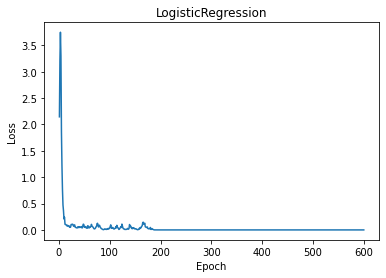

In [31]:
plt.plot(range(1, len(loss_each_epoch_LR) + 1), loss_each_epoch_LR)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LogisticRegression')

In [32]:
print('Logistic Regression (Train Accuracy)')
model_evaluation(data_loader=train_loader, model=clf_LR)

Logistic Regression (Train Accuracy)
We got 457/457 correct. Accuracy = 100.00%


In [33]:
print('Logistic Regression (Test Accuracy)')
model_evaluation(data_loader=test_loader, model=clf_LR)

Logistic Regression (Test Accuracy)
We got 152/197 correct. Accuracy = 77.16%


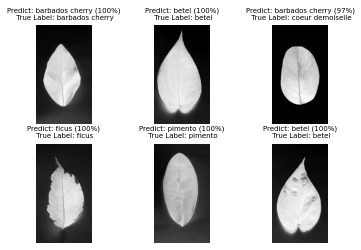

In [34]:
ROW_IMG, N_ROWS = 3, 2

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_dataset[index][0].squeeze(), cmap='gray_r')
    
    with torch.no_grad():
        clf_LR.eval()
        X = test_dataset[index][0].reshape(test_dataset[index][0].shape[0], -1).to(device)
        _, probs = clf_LR(X)
    title = f'Predict: {le.inverse_transform([torch.argmax(probs).item()])[0]} ({torch.max(probs * 100):.0f}%)\n True Label: {le.inverse_transform([test_dataset[index][-1]])[0]}'
    
    plt.title(title, fontsize=7)
plt.show()

In [35]:
# Task: Build a MLP model with 6 layers (input layer, ouput layer and 4 hidden layers)
# The activation of each node in 'input' layer and 'hidden' layers is ReLU
# Information about each layer:
# + Input layer: (input_dim, 2048)
# + Hidden layer 1: (2048, 1024)
# + Hidden layer 2: (1024, 1024)
# + Hidden layer 3: (1024, 512)
# + Hidden layer 4: (512, 512)
# + Output layer: (512, output_dim)

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs


In [36]:
clf_MLP = MLP(input_dim=412 * 232, output_dim=32).to(device)
clf_MLP

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=95584, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=32, bias=True)
  )
)

In [39]:
# Train MLP model
# Input dim = 412 * 233
# Output dim = 32
# Initial Learning Rate: 0.001
# Max Epoch = 600
loss_each_epoch_MLP = train_model(train_loader, clf_MLP, 0.001, 600)

Epoch 1/600, Loss: 0.08
Epoch 2/600, Loss: 0.06
Epoch 3/600, Loss: 0.06
Epoch 4/600, Loss: 0.06
Epoch 5/600, Loss: 0.06
Epoch 6/600, Loss: 0.06
Epoch 7/600, Loss: 0.06
Epoch 8/600, Loss: 0.06
Epoch 9/600, Loss: 0.06
Epoch 10/600, Loss: 0.05
Epoch 11/600, Loss: 0.05
Epoch 12/600, Loss: 0.05
Epoch 13/600, Loss: 0.05
Epoch 14/600, Loss: 0.05
Epoch 15/600, Loss: 0.05
Epoch 16/600, Loss: 0.05
Epoch 17/600, Loss: 0.05
Epoch 18/600, Loss: 0.04
Epoch 19/600, Loss: 0.04
Epoch 20/600, Loss: 0.04
Epoch 21/600, Loss: 0.04
Epoch 22/600, Loss: 0.04
Epoch 23/600, Loss: 0.04
Epoch 24/600, Loss: 0.04
Epoch 25/600, Loss: 0.04
Epoch 26/600, Loss: 0.04
Epoch 27/600, Loss: 0.04
Epoch 28/600, Loss: 0.04
Epoch 29/600, Loss: 0.03
Epoch 30/600, Loss: 0.03
Epoch 31/600, Loss: 0.03
Epoch 32/600, Loss: 0.03
Epoch 33/600, Loss: 0.03
Epoch 34/600, Loss: 0.03
Epoch 35/600, Loss: 0.03
Epoch 36/600, Loss: 0.03
Epoch 37/600, Loss: 0.03
Epoch 38/600, Loss: 0.03
Epoch 39/600, Loss: 0.03
Epoch 40/600, Loss: 0.03
Epoch 41/

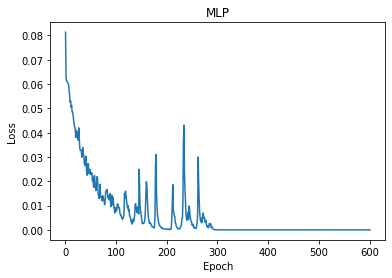

In [40]:
plt.plot(range(1, len(loss_each_epoch_MLP) + 1), loss_each_epoch_MLP)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP')
plt.show()

In [41]:
print('Multi Layer Perceptron (Train Accuracy)')
model_evaluation(train_loader, clf_MLP)

Multi Layer Perceptron (Train Accuracy)
We got 457/457 correct. Accuracy = 100.00%


In [42]:
print('Multi Layer Perceptron (Test Accuracy)')
model_evaluation(test_loader, clf_MLP)

Multi Layer Perceptron (Test Accuracy)
We got 145/197 correct. Accuracy = 73.60%


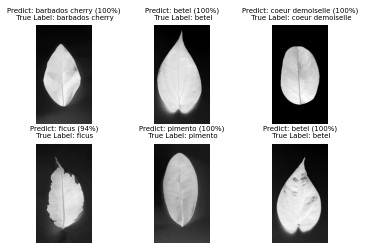

In [43]:
ROW_IMG, N_ROWS = 3, 2

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_dataset[index][0].squeeze(), cmap='gray_r')
    
    with torch.no_grad():
        clf_MLP.eval()
        X = test_dataset[index][0].reshape(test_dataset[index][0].shape[0], -1).to(device)
        _, probs = clf_MLP(X)
    title = f'Predict: {le.inverse_transform([torch.argmax(probs).item()])[0]} ({torch.max(probs * 100):.0f}%)\n True Label: {le.inverse_transform([test_dataset[index][-1]])[0]}'
    
    plt.title(title, fontsize=7)
plt.show()